In [6]:
import os
import shutil
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [7]:
%ls

 Volume in drive C is OS
 Volume Serial Number is 6682-3876

 Directory of c:\Users\Sarthak\Documents\GitHub\skincancer

16-10-2024  16:48    <DIR>          .
12-10-2024  19:03    <DIR>          ..
16-10-2024  16:48    <DIR>          .vscode
20-10-2024  10:21    <DIR>          api
16-10-2024  15:41    <DIR>          data
20-10-2024  10:19    <DIR>          frontend
16-10-2024  16:39    <DIR>          gcp
16-10-2024  16:36    <DIR>          models
22-09-2024  12:45         6,360,347 now-work-skin-cacner.ipynb
18-10-2024  19:50           621,826 train.ipynb
06-09-2024  06:39    <DIR>          training
               2 File(s)      6,982,173 bytes
               9 Dir(s)  53,312,069,632 bytes free


In [8]:
# Paths to the images
image_path1 = r'.\data\HAM10000_images_part_1'
image_path2 = r'.\data\HAM10000_images_part_2'

# Directory for the final combined images
final_image_dataset = './data/skin-cancer-mnist-ham10000_combined'


In [9]:
os.getcwd()+final_image_dataset

'c:\\Users\\Sarthak\\Documents\\GitHub\\skincancer./data/skin-cancer-mnist-ham10000_combined'

In [10]:
# Create the destination folder if it doesn't exist
os.makedirs(final_image_dataset, exist_ok=True)

In [27]:
def copy_images(source_path, destination_path):
    for filename in os.listdir(source_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            shutil.copy(os.path.join(source_path, filename), destination_path)

In [28]:
# Copy images from both folders to the final directory
copy_images(image_path1, final_image_dataset)
copy_images(image_path2, final_image_dataset)

In [11]:
metadata_path = './data/HAM10000_metadata.csv'
meta_data = pd.read_csv(metadata_path)

# Add a new column for the image paths in the combined folder
meta_data['Image_path'] = meta_data['image_id'].apply(lambda x: os.path.join(final_image_dataset, f"{x}.jpg"))

# Initialize and fit LabelEncoder
le = LabelEncoder()
meta_data['label'] = le.fit_transform(meta_data["dx"])

# Convert labels to string format
meta_data['label'] = meta_data['label'].astype(str)

# Resample to balance the dataset
n_samples = 4500 # Maximum count of the 'nv' class

# Separate each class
df_nv = meta_data[meta_data['dx'] == 'nv']
df_mel = meta_data[meta_data['dx'] == 'mel']
df_bkl = meta_data[meta_data['dx'] == 'bkl']
df_bcc = meta_data[meta_data['dx'] == 'bcc']
df_akiec = meta_data[meta_data['dx'] == 'akiec']
df_vasc = meta_data[meta_data['dx'] == 'vasc']
df_df = meta_data[meta_data['dx'] == 'df']

In [12]:
# Balance the classes
df_nv_balanced = resample(df_nv, replace=False, n_samples=n_samples, random_state=42)
df_mel_balanced = resample(df_mel, replace=True, n_samples=n_samples, random_state=42)
df_bkl_balanced = resample(df_bkl, replace=True, n_samples=n_samples, random_state=42)
df_bcc_balanced = resample(df_bcc, replace=True, n_samples=n_samples, random_state=42)
df_akiec_balanced = resample(df_akiec, replace=True, n_samples=n_samples, random_state=42)
df_vasc_balanced = resample(df_vasc, replace=True, n_samples=n_samples, random_state=42)
df_df_balanced = resample(df_df, replace=True, n_samples=n_samples, random_state=42)

In [13]:
balanced_meta_data = pd.concat([df_nv_balanced, df_mel_balanced, df_bkl_balanced,
                        df_bcc_balanced, df_akiec_balanced, df_vasc_balanced,
                        df_df_balanced])
# Mapping labels to their full names
label_mapping = {
'nv': 'Melanocytic Nevus',
'mel': 'Melanoma',
'bkl': 'Benign Keratosis',
'bcc': 'Basal Cell Carcinoma',
'akiec': 'Actinic Keratosis',
'vasc': 'Vascular Lesion',
'df': 'Dermatofibroma'
}

# Replace the labels with full names
balanced_meta_data['dx'] = balanced_meta_data['dx'].replace(label_mapping)

# Now, balanced_meta_data['dx'] will contain the full names
print(balanced_meta_data['dx'].value_counts())

# Shuffle the combined dataset
balanced_meta_data = balanced_meta_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset class distribution:\n{balanced_meta_data['dx'].value_counts()}")

dx
Melanocytic Nevus       4500
Melanoma                4500
Benign Keratosis        4500
Basal Cell Carcinoma    4500
Actinic Keratosis       4500
Vascular Lesion         4500
Dermatofibroma          4500
Name: count, dtype: int64
Balanced dataset class distribution:
dx
Basal Cell Carcinoma    4500
Melanocytic Nevus       4500
Actinic Keratosis       4500
Dermatofibroma          4500
Melanoma                4500
Vascular Lesion         4500
Benign Keratosis        4500
Name: count, dtype: int64


In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Perform initial train-test split without stratification
train_meta, test_meta = train_test_split(balanced_meta_data, test_size=0.3, random_state=42)
train_meta, val_meta = train_test_split(train_meta, test_size=0.3, random_state=42)

print(f"Training set size: {len(train_meta)}")
print(f"Validation set size: {len(val_meta)}")
print(f"Testing set size: {len(test_meta)}")

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
dataframe=train_meta,
directory='.',
x_col='Image_path',
y_col='label',
target_size=(128, 128),
batch_size=32,
class_mode='categorical'
)

# Validation generator
val_generator = test_datagen.flow_from_dataframe(
dataframe=val_meta,
directory='.',
x_col='Image_path',
y_col='label',
target_size=(128,128),
batch_size=32,
class_mode='categorical',
shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
dataframe=test_meta,
directory='.',
x_col='Image_path',
y_col='label',
target_size=(128, 128),
batch_size=32,
class_mode='categorical',
shuffle=False
)

Training set size: 15435
Validation set size: 6615
Testing set size: 9450
Found 15435 validated image filenames belonging to 7 classes.
Found 6615 validated image filenames belonging to 7 classes.
Found 9450 validated image filenames belonging to 7 classes.


In [15]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Define the number of classes
num_classes = 7

# Define the model
model = Sequential()

# First Conv2D layer
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Second Conv2D layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Conv2D layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fourth Conv2D layer
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Global Average Pooling layer (instead of Flatten)
model.add(GlobalAveragePooling2D())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 128)      5

In [16]:
history = model.fit(
train_generator,
validation_data=val_generator,
epochs=50
)

Epoch 1/50
483/483 [==============================] - 208s 422ms/step - loss: 1.5913 - accuracy: 0.3965 - val_loss: 2.3701 - val_accuracy: 0.2231
Epoch 2/50
483/483 [==============================] - 194s 401ms/step - loss: 1.3229 - accuracy: 0.4931 - val_loss: 1.5599 - val_accuracy: 0.4558
Epoch 3/50
483/483 [==============================] - 191s 395ms/step - loss: 1.2178 - accuracy: 0.5402 - val_loss: 1.4262 - val_accuracy: 0.5359
Epoch 4/50
483/483 [==============================] - 195s 402ms/step - loss: 1.1411 - accuracy: 0.5695 - val_loss: 1.3218 - val_accuracy: 0.5660
Epoch 5/50
483/483 [==============================] - 190s 394ms/step - loss: 1.0649 - accuracy: 0.6017 - val_loss: 1.3826 - val_accuracy: 0.5545
Epoch 6/50
483/483 [==============================] - 187s 387ms/step - loss: 1.0169 - accuracy: 0.6174 - val_loss: 2.0987 - val_accuracy: 0.4925
Epoch 7/50
483/483 [==============================] - 187s 387ms/step - loss: 0.9636 - accuracy: 0.6432 - val_loss: 1.3876 -

In [17]:
import matplotlib.pyplot as plt
# Evaluate test accuracy
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

296/296 [==============================] - 62s 210ms/step - loss: 2.7255 - accuracy: 0.4299
Test Accuracy: 0.4299


296/296 [==============================] - 59s 200ms/step


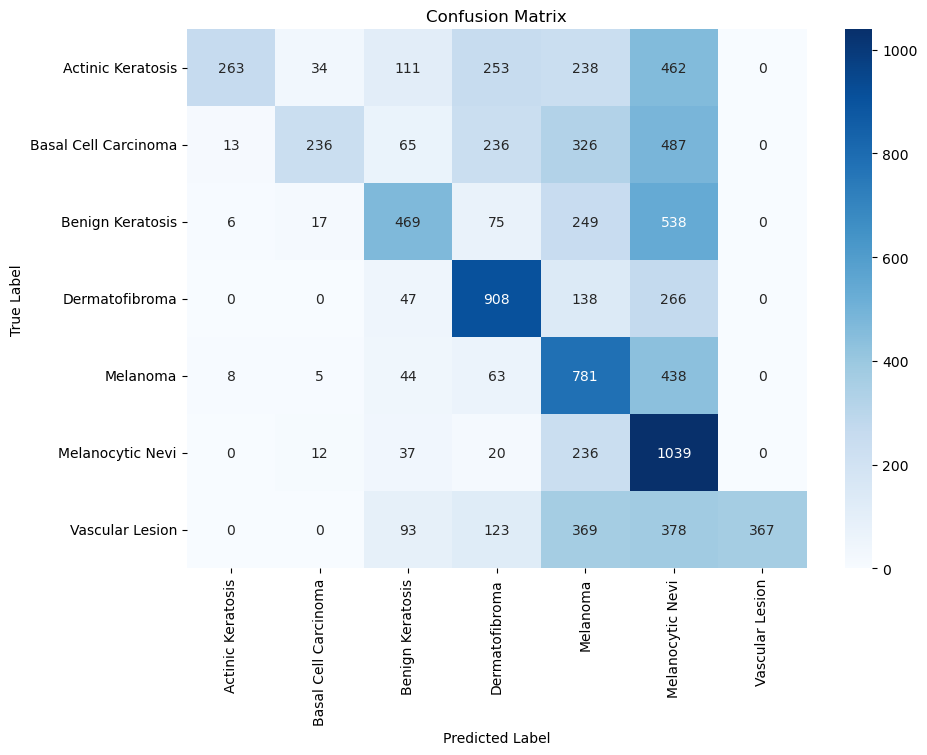


Classification Report:

                      precision    recall  f1-score   support

   Actinic Keratosis       0.91      0.19      0.32      1361
Basal Cell Carcinoma       0.78      0.17      0.28      1363
    Benign Keratosis       0.54      0.35      0.42      1354
      Dermatofibroma       0.54      0.67      0.60      1359
            Melanoma       0.33      0.58      0.42      1339
    Melanocytic Nevi       0.29      0.77      0.42      1344
     Vascular Lesion       1.00      0.28      0.43      1330

            accuracy                           0.43      9450
           macro avg       0.63      0.43      0.41      9450
        weighted avg       0.63      0.43      0.41      9450

Overall Accuracy: 0.4299
Precision (Weighted): 0.6270
Recall (Weighted): 0.4299
F1-Score (Weighted): 0.4140


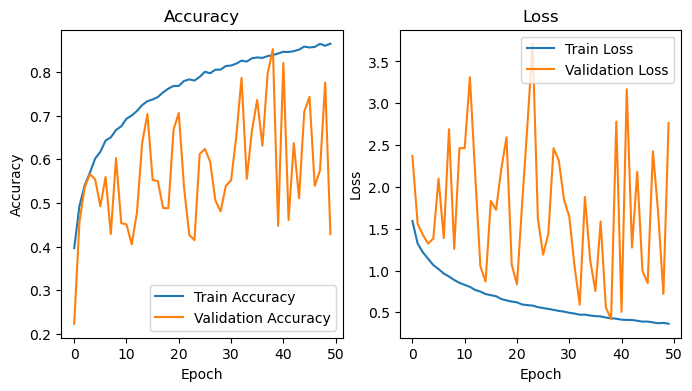

In [18]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# # Evaluate test accuracy
# test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
# print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Define the 7 skin cancer class labels
class_labels = {
    0: 'Actinic Keratosis',    # akiec
    1: 'Basal Cell Carcinoma', # bcc
    2: 'Benign Keratosis',     # bkl
    3: 'Dermatofibroma',       # df
    4: 'Melanoma',            # mel
    5: 'Melanocytic Nevi',    # nv
    6: 'Vascular Lesion'      # vasc
}


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels.values()))

# Additional metrics: Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print additional evaluation metrics
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")

# Plot evaluation metrics over epochs
def plot_metrics(history):
    plt.figure(figsize=(8, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Assuming you have the history object from model.fit
plot_metrics(history)

In [19]:
model= tf.keras.models.load_model("./models/first_model.h5")

1/1 [==============================] - 0s 24ms/step


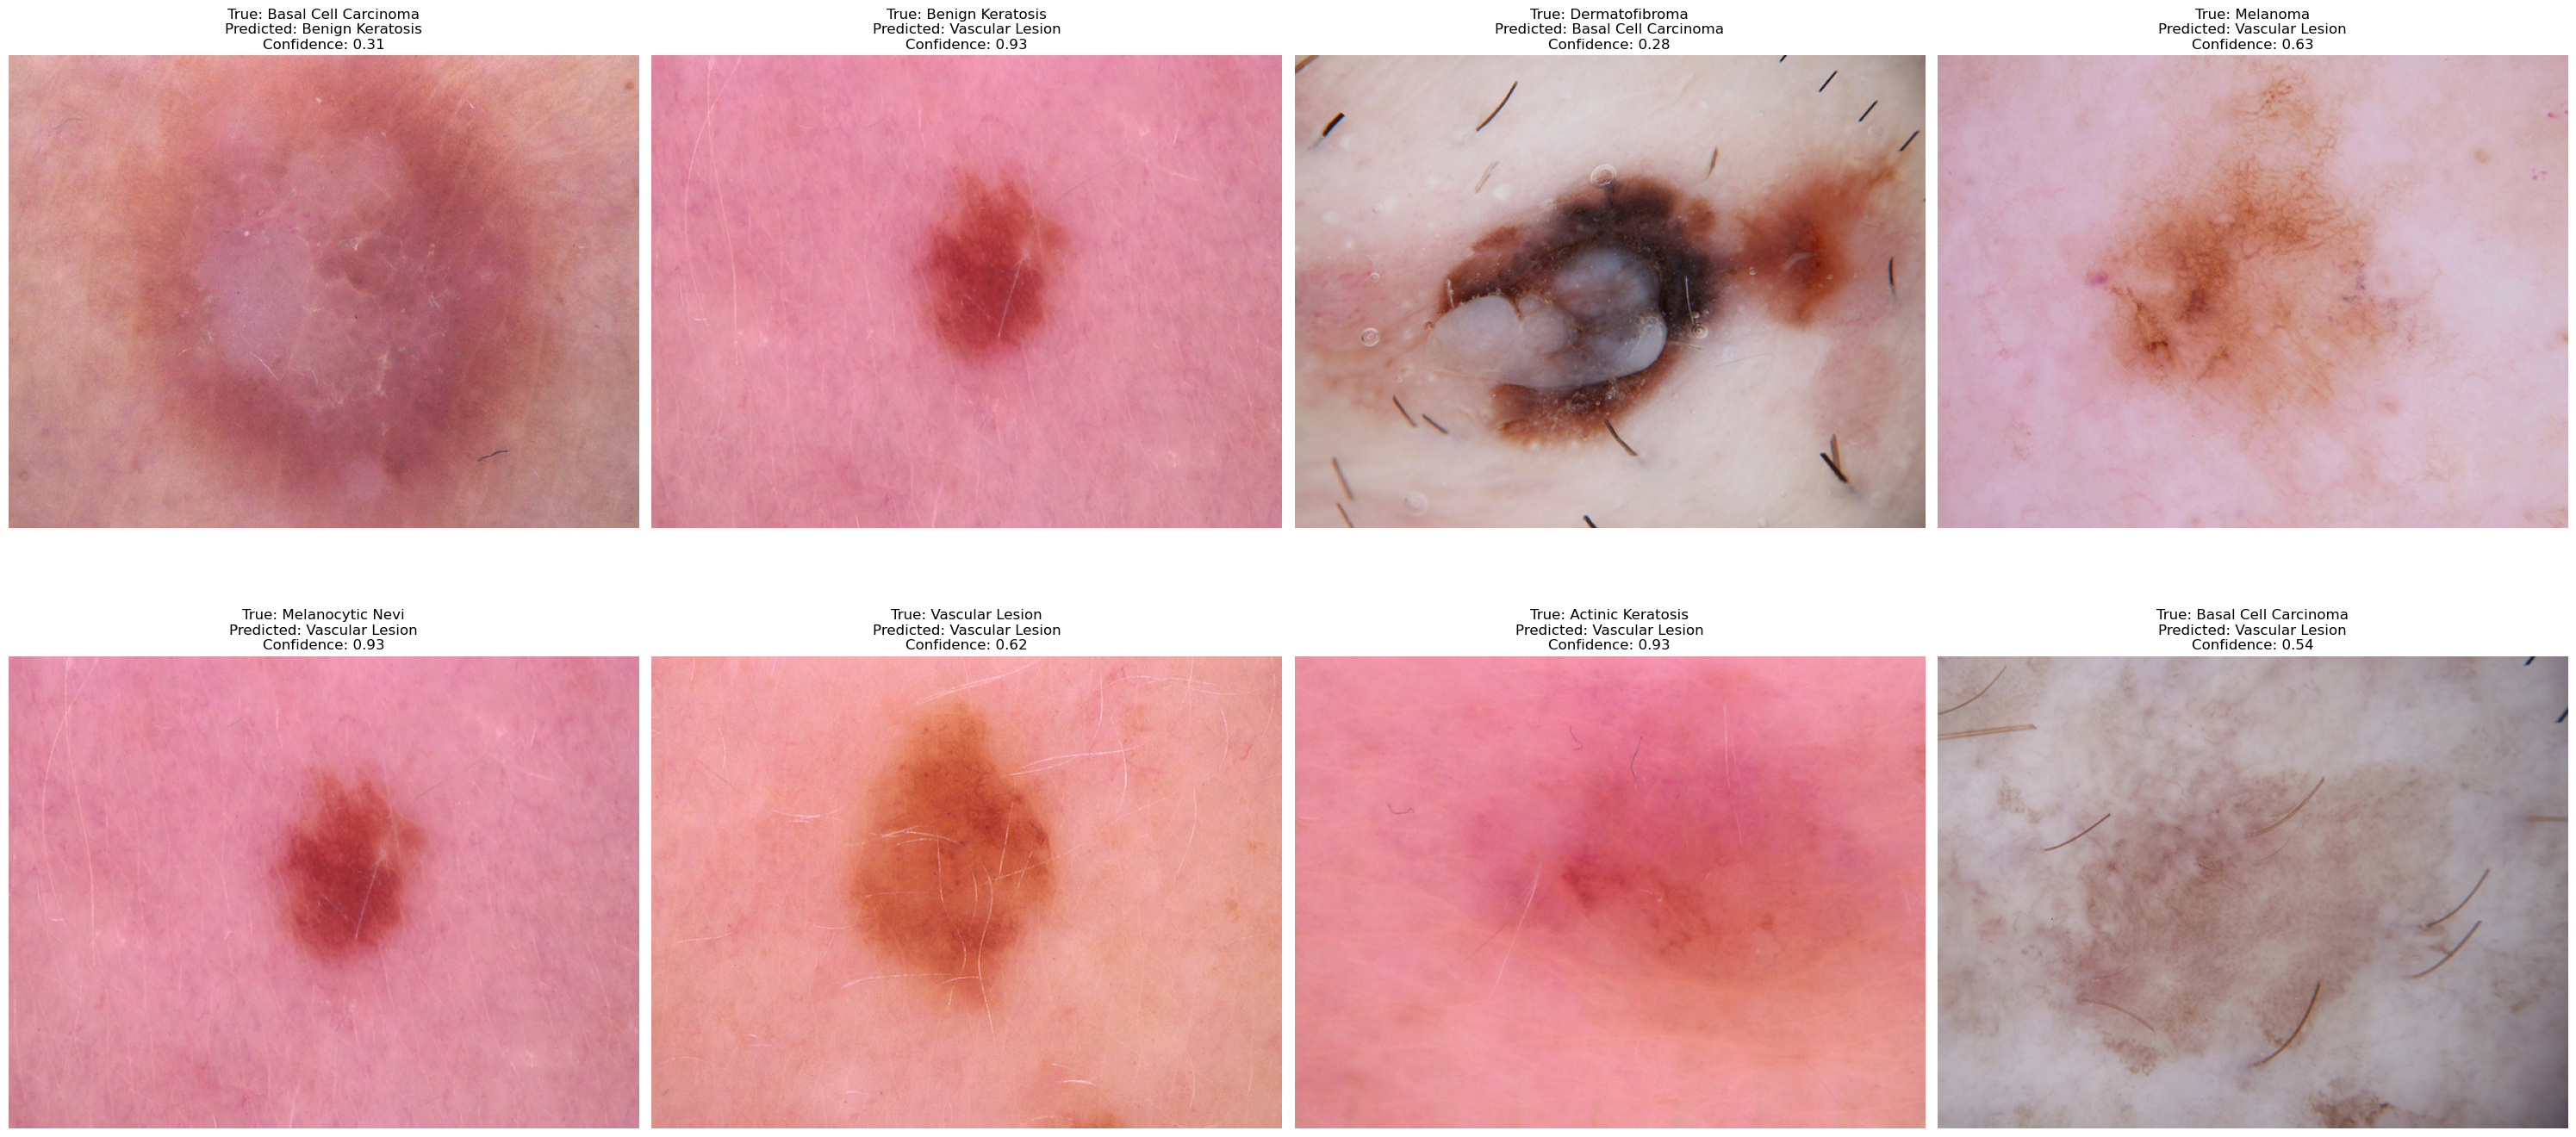

In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def classify_and_plot_images(model, image_paths, true_labels):
    plt.figure(figsize=(30, 15))

    for i, image_path in enumerate(image_paths):
        img = load_img(image_path, target_size=(128,128))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        confidence = np.max(prediction)

        plt.subplot(2, 4, i + 1)
        plt.imshow(load_img(image_path))
        plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_class]}\nConfidence: {confidence:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

sample_image_paths = [
    "./data/skin-cancer-mnist-ham10000_combined/ISIC_0030870.jpg",
    "./data/skin-cancer-mnist-ham10000_combined/ISIC_0026915.jpg",
    "./data/skin-cancer-mnist-ham10000_combined/ISIC_0026229.jpg",
    "./data/skin-cancer-mnist-ham10000_combined/ISIC_0028511.jpg",
    "./data/skin-cancer-mnist-ham10000_combined/ISIC_0026915.jpg",
    "./data/skin-cancer-mnist-ham10000_combined/ISIC_0030351.jpg",
    "./data/skin-cancer-mnist-ham10000_combined/ISIC_0026932.jpg",
    "./data/skin-cancer-mnist-ham10000_combined/ISIC_0027953.jpg",
]

sample_true_labels = [1, 2, 3, 4, 5, 6, 0, 1]
classify_and_plot_images(model, sample_image_paths, sample_true_labels)



In [1]:
model_version = max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"./models/{model_version}")

NameError: name 'os' is not defined